In [1]:
import pyro
import torch
import wandb
import os

import numpy as np

from pyro.infer.autoguide import AutoMultivariateNormal, AutoLowRankMultivariateNormal, init_to_mean
from inference.bayesian.models import TorchModel, BayesianModel
from inference.bayesian.utils import plot_forecast
from inference.inference import inference
from ESN.utils import run_esn

In [2]:
config = {
            "dataset": "spain",
            "model_widths": [512, 1],
            "activation": "tanh",
            "distributions": ["gauss", "unif", "gauss"],
            "parameters": [[0,1],[0,1]],
            "dim_reduction": False,
            "num_samples": 2000,
            "inference": "svi",
            "lr": 0.01,
            "num_iterations": 2000,
            "plot": False,
            "sweep": False
            }

os.environ["WANDB_MODE"]="offline"
os.environ["WANDB_NOTEBOOK_NAME"]="main_svi.ipynb"
wandb.init(project="bayes_rc", config=config)
config = wandb.config

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
Ytr, train_embedding, Yval, val_embedding, Yte, test_embedding, diffXte, diffYte = run_esn(config.dataset, device, dim_reduction=config.dim_reduction)

Tr: 907, Val: 455, Te: 455


# SVI

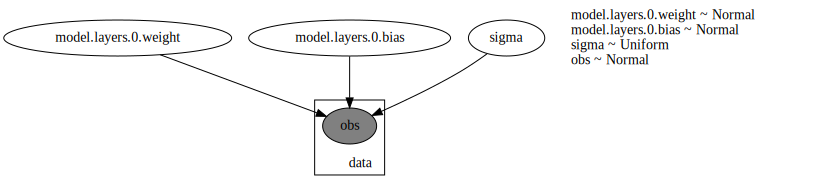

In [5]:
torch_model = TorchModel(config.model_widths, config.activation).to(device)
svi_model = BayesianModel(torch_model, config, device)
svi_model.render_model(model_args=(train_embedding[0], Ytr[0]))

Autoguide for testing

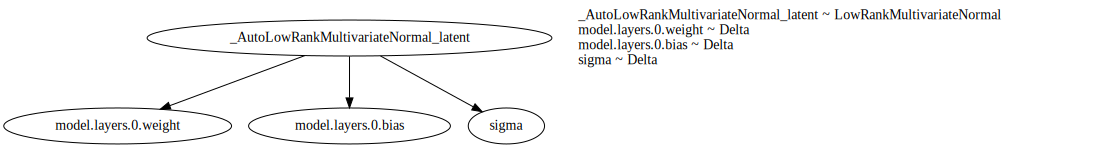

In [6]:
pyro.clear_param_store()

# To enforce all the parameters in the guide on the GPU, since we use an autoguide
if device != 'cpu':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

guide = AutoLowRankMultivariateNormal(svi_model, init_loc_fn=init_to_mean)
# A full multivariate normal saturates gpu memory, the covariance matrix is too big
# guide = AutoMultivariateNormal(svi_model, init_loc_fn=init_to_mean)
pyro.render_model(guide, model_args=(train_embedding[0], Ytr[0]), render_distributions=True)

In [8]:
for n, p in pyro.get_param_store().items():
    print(f"{n}, shape: {p.shape}")

AutoLowRankMultivariateNormal.loc, shape: torch.Size([514])
AutoLowRankMultivariateNormal.scale, shape: torch.Size([514])
AutoLowRankMultivariateNormal.cov_factor, shape: torch.Size([514, 23])


In [7]:
# Quantiles
quantiles = [0, 0.005]
for n in range(39):
    quantiles.append(0.025*(n+1))
quantiles.append(0.995)

In [8]:
predictive, diagnostics = inference(config, svi_model, guide,
                                    X_train=train_embedding, Y_train=Ytr,
                                    X_val=val_embedding, Y_val=Yval, 
                                    X_test=test_embedding, Y_test=Yte,
                                    quantiles=quantiles)

Epoch 2000: 100%|██████████| 2000/2000 [00:11<00:00, 171.42it/s, loss=2.17]


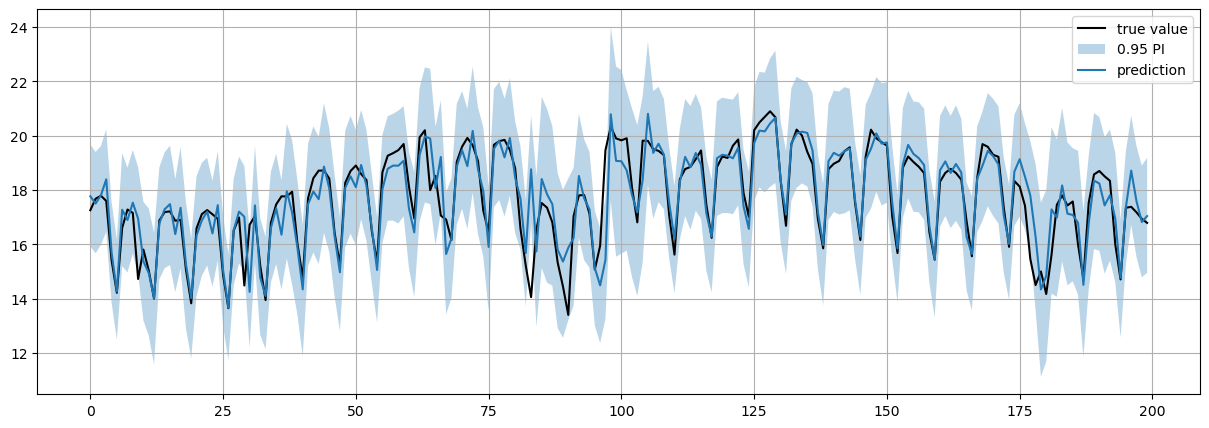

In [10]:
plot_forecast(predictive, Yte, diffXte.squeeze(), diffYte.squeeze(), "svi", 200)

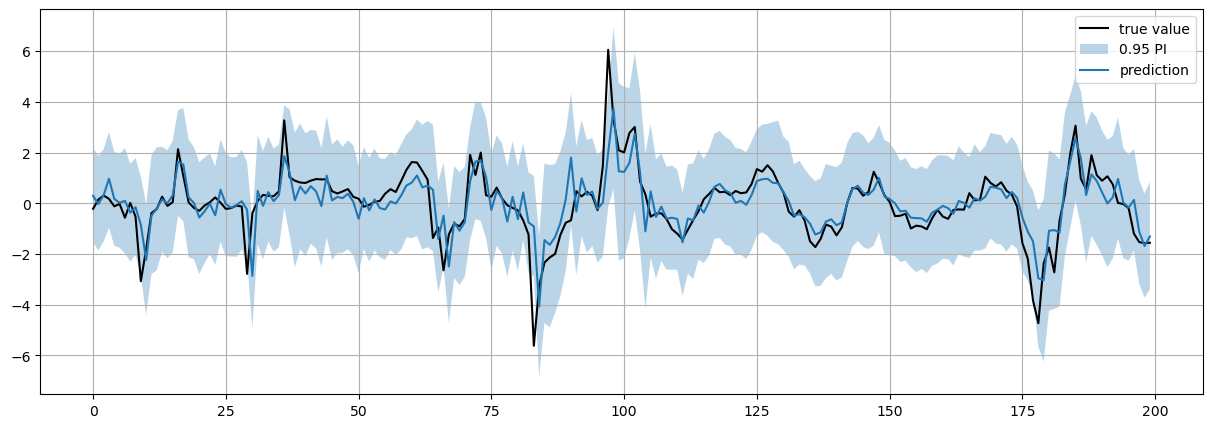

In [11]:
plot_forecast(predictive, Yte, np.zeros_like(diffXte.squeeze()), np.zeros_like(diffYte.squeeze()), "svi", 200)

In [9]:
for k, v in diagnostics.items():
    print(k)

train_time
quantiles
cal_error
crps


In [16]:
print("training time: ", diagnostics['train_time'])
print("calibration error: ", diagnostics['cal_error'])
print("Continuous ranked probability score: ", diagnostics['crps'])

training time:  0.125
calibration error:  0.7237016307764278
Continuous ranked probability score:  0.7199954042202141


In [ ]:
# to save a session
import dill

dill.dump_session('dump/notebook_16122022.db')

In [ ]:
# to load a session
dill.load_session('notebook_env.db')